## Homework 1 solution

Let's use the following convention for numbering legs:
```
 1--A--3
    |
    2
```

In [1]:
using TensorOperations
using LinearMaps

In [2]:
"""
    rand_UMPS(d, D; keep_it_real=true)

Return a random three-valent tensor A, that defines a uniform MPS (UMPS).
The bond dimension of the physical leg should be d, and the bond dimension
of the two "virtual" legs (the horizontal ones) should be D.
keep_it_real is keyword argument, for whether the matrix should be real or
complex.

This means you can call
`rand_UMPS(2, 9)`
or
`rand_UMPS(2, 9; keep_it_real=true)`
and they both give a you real A, but you can also call
`rand_UMPS(2, 9; keep_it_real=false)`
to get a complex A.
"""
function rand_UMPS(d, D; keep_it_real=true)
    shp = (D, d, D)
    if keep_it_real
        A = randn(shp)
    else
        A_real = randn(shp)
        A_imag = randn(shp)
        A = complex.(A_real, A_imag) / sqrt(2)
    end
    return A
end

rand_UMPS

In [3]:
"""
    tm(A)

Return the transfer matrix of A:
 --A---
   |  
 --A*--
"""
function tm(A)
    @tensor T[i1,i2,j1,j2] := A[i1,p,j1]*conj(A)[i2,p,j2]
end

tm

In [4]:
function eig_and_trunc(T, nev; by=identity, rev=false)
    S, U = eig(T)
    perm = sortperm(S; by=by, rev=rev)
    S = S[perm]
    U = U[:, perm]
    S = S[1:nev]
    U = U[:, 1:nev]
    return S, U
end

"""
    tm_eigs(A, dirn, nev)

Return some of the eigenvalues and vectors of the transfer matrix of A.
dirn should be "L", "R" or "BOTH", and determines which eigenvectors to return.
nev is the number of eigenpairs to return (starting with the eigenvalues with
largest magnitude).
"""
function tm_eigs_dense(A, dirn, nev)
    T = tm(A)
    D = size(T, 1)
    T = reshape(T, (D^2, D^2))
    nev = min(nev, D^2)
    
    result = ()
    if dirn == "R" || dirn == "BOTH"
        SR, UR = eig_and_trunc(T, nev; by=abs, rev=true)
        UR = [reshape(UR[:,i], (D, D)) for i in 1:nev]
        result = tuple(result..., SR, UR)
    end
    if dirn == "L" || dirn == "BOTH"
        SL, UL = eig_and_trunc(T', nev; by=abs, rev=true)
        UL = [reshape(UL[:,i], (D, D)) for i in 1:nev]
        result = tuple(result..., SL, UL)
    end
    return result
end

tm_eigs_dense

In [5]:
"""
    tm_l(A, x)

Return y, where
/------   /------A--
|       = |      |  
\- y* -   \- x* -A*-
"""
function tm_l(A, x)
    @tensor y[i, j] := (x[a, b] * A[b, p, j]) * conj(A[a, p, i])
    return y
end


"""
    tm_r(A, x)

Return y, where
-- y -\   --A-- x -\
      | =   |      |
------/   --A*-----/
"""
function tm_r(A, x)
    @tensor y[i, j] := A[i, p, a] * (conj(A[j, p, b]) * x[a, b])
    return y
end


tm_r

In [6]:
function tm_eigs_sparse(A, dirn, nev)
    if dirn == "BOTH"
        SR, UR = tm_eigs_sparse(A, "R", nev)
        SL, UL = tm_eigs_sparse(A, "L", nev)
        return SR, UR, SL, UL
    else
        D = size(A, 1)
        x = zeros(eltype(A), (D, D))
        if dirn == "L"
            f = v -> vec(tm_l(A, copy!(x, v)))
        else
            f = v -> vec(tm_r(A, copy!(x, v)))
        end

        fmap = LinearMap{eltype(A)}(f, D^2)
        S, U, nconv, niter, nmult, resid = eigs(fmap, nev=nev, which=:LM, ritzvec=true)
        U = [reshape(U[:,i], (D, D)) for i in 1:size(U, 2)]

        return S, U
    end
end

tm_eigs_sparse (generic function with 1 method)

In [7]:
function tm_eigs(A, dirn, nev; max_dense_D=10)
    D = size(A, 1)
    if D <= max_dense_D || nev >= D^2
        return tm_eigs_dense(A, dirn, nev)
    else
        return tm_eigs_sparse(A, dirn, nev)
    end
end

tm_eigs (generic function with 1 method)

In [8]:
"""
    normalize!(A)

Normalize the UMPS defined by A, and return the dominant left and right
eigenvectors l and r of its transfer matrix, normalized so that l'*r = 1.
"""
function normalize!(A)
    SR, UR, SL, UL = tm_eigs(A, "BOTH", 1)
    S1 = SR[1]
    A ./= sqrt(S1)
    
    l = UL[1]
    r = UR[1]  
    #We need this to be 1
    n = vec(l)'*vec(r)
    abs_n = abs(n)
    phase_n = abs_n/n
    sfac = 1.0/sqrt(abs_n)
    l .*= sfac/phase_n
    r .*= sfac
    return l, r
end

normalize!

## Homework 2 solution

In [9]:
"""
    tm_l_op(A, O, x)

Return y, where
/------   /------A--
|         |      |  
|       = |      O  
|         |      |  
\- y* -   \- x* -A*-
"""
function tm_l_op(A, O, x)
    @tensor y[i, j] := (x[a, b] * A[b, p2, j]) * (conj(A[a, p1, i]) * conj(O[p1, p2]))
    return y
end


"""
    tm_r_op(A, O, x)

Return y, where
-- y -\   --A-- x -\
      |     |      |
      | =   O      |
      |     |      |
------/   --A*-----/
"""
function tm_r_op(A, O, x)
    @tensor y[i, j] := (A[i, p1, a] * O[p1, p2]) * (conj(A[j, p2, b]) * x[a, b])
    return y
end


tm_r_op

In [10]:
"""
    expect_local(A, O, l, r)

Return the expectation value of the one-site operator O for the UMPS state
defined by the tensor A.
"""
function expect_local(A, O, l, r)
    l = tm_l_op(A, O, l)
    expectation = vec(l)'*vec(r)
    return expectation
end

expect_local

In [11]:
"""
    correlator_twopoint(A, O1, O2, m, l, r)

Return the (connected) two-point correlator of operators O1 and O2 for the
state UMPS(A), when O1 and O2 are i sites apart, where i ranges from 1 to m. In
other words, return <O1_0 O2_i> - <O1> <O2>, for all i = 1,...,m, where the
expectation values are with respect to the state |UMPS(A)>.
"""
function correlator_twopoint(A, O1, O2, m, l, r)
    local_O1 = expect_local(A, O1, l, r)
    local_O2 = expect_local(A, O2, l, r)
    disconnected = local_O1 * local_O2
    
    l = tm_l_op(A, O1, l)
    r = tm_r_op(A, O2, r)
    
    result = zeros(eltype(A), m)
    result[1] = vec(l)'*vec(r) - disconnected
    for i in 1:m
        r = tm_r(A, r)
        result[i] = vec(l)'*vec(r) - disconnected
    end
    return result
end

correlator_twopoint

In [12]:
"""
    correlation_length(A)

Return the correlation length ξ of the UMPS defined by A. ξ = - 1/ln(|lambda[2]|),
where lambda[2] is the eigenvalue of the MPS transfer matrix with second largest
magnitude. (We assume here that UMPS(A) is normalized.)
"""
function correlation_length(A)
    S, U = tm_eigs(A, "L", 2)
    s2 = S[2]
    ξ = -1/log(abs(s2))
    return ξ
end

correlation_length

# But I don't care about random MPSes!

Now that you know how to compute correlation functions for MPS states, we should start thinking about how do we get a useful MPS state in the first place. So far all our states have been defined by tensors $A$ with random elements.

Some fun little analytical examples exist, such as how to represent GHZ or W states as MPSes. You should google them up. The real question is though, given an arbitrary local Hamiltonian, can we find an MPS for the ground state. We know that for gapped Hamiltonians (i.e. most Hamiltonians) correlations in the ground state decay exponentially and entanglement is limited, so there's hope that the answer would be "yes we can".

You can think about this problem in a few different ways. One is to ask, what's the lowest energy state we can find on the manifold of MPS states. The question is then a matter of optimizing for minimal expectation value $\langle \psi | H | \psi \rangle$ under the constraint that the state $|\psi \rangle$ is an MPS. Another way to approach this would be writing down some expression for the exact ground state (an expression we obviously can't just go an evaluate, otherwise there would be no problem), and then try to massage that expression into an MPS.

Various algorithms for implementing these different approaches in different situations (finite-size, infinite-size, translation invariant or not, what kind of boundary conditions) exist. Some examples are the Density Matrix Renormalization Group (DMRG), Time-Dependent Variational Principle (TDVP) and Time-Evolving Block Decimation (TEBD). We'll implement an infinite-lattice version of TEBD. Why TEBD? Because it's simple, and because it you can also use it to do time-evolution of MPS states. (I maintain that the choice to pick TEBD is independent of the fact that Guifre invented it.)

Implementing iTEBD will be the rest of this minicourse. However, we'll only really get to that next time. First, we need to talk a bit about gauge freedom in MPS and how to fix this freedom, since TEBD will be making use of a specific gauge.

## Gauge freedom and canonical forms
In any tensor network, I can always take any contracted leg, and insert on that leg a pair of invertibale matrices $g g^{-1} = \mathbb{1}$. This doesn't affect the value the network contracts to in anyway: I've just changed the basis in which I perform one of the sums (traces).

This means that an MPS representation of a state is not unique. I can insert any $g g^{-1}$ on any of the virtual legs of the MPS, and the state stays the same. Obviously, I would like to stay within the framework of translation invariant MPSes, so I allow only for gauge transformations (as these changes of basis are called) of the form
```
--A-- -> --gi--A--g--
  |            |
```
where by `gi` I mean the inverse of $g$.

Since we have some freedom in picking $A$, we should probably try to make use of it somehow, while fixing the freedom. How? Well, we could try to impose some nice properties on $A$, if such a property can be achieved by a gauge transformation. And it turns out there's a really useful property that we can impose, which goes as follows.

First, we have to complicate our setup slightly. Previously our how MPS was defined by $A$. Now, let's think of an MPS that is instead written as
```
... --λ--Γ--λ--Γ--λ--Γ--λ-- ...
         |     |     |
```
Here $\Gamma$ is some tensor, and $\lambda$ is a diagonal matrix. Obviously we could just absorb $\lambda$ into $\Gamma$ and a get single tensor $A$. The point is, by using the gauge freedom, we can choose $\Gamma$ and $\lambda$ in such a way, that *$\lambda$ always has on its diagonal the Schmidt coefficients of partitioning the state into two parts at $\lambda$*. What are Schmidt coefficients? https://en.wikipedia.org/wiki/Schmidt_decomposition

Another way of stating the same condition is to say that the left dominant eigenvector of
```
--λ--Γ--
     |
--λ--Γ--
```
and the right dominant eigenvector of
```
--Γ--λ--
  |
--Γ--λ--
```
are both the identity matrix.

Choosing our gauge so that this property holds, turns out to be quite handy. You'll see next time how it's used in the TEBD algorithm, but you can probably already imagine that it's kinda nice that on each virtual legs you have these Schmidt coefficients $\lambda$, that immediately tell you everything you would want to know about the entanglement between the two sides of the state separated by this leg. The bond dimension is also obviously the Schmidt rank, which gives us a very concrete, physical characterization of what high bond dimension and low bond dimension mean.

So, given $A$, how do we find a gauge transformation such that the above property holds? I'm getting tired of typing, so just go read Section II of https://arxiv.org/pdf/0711.3960.pdf, that will explain it all. Then, it's time to define your homework.

## Homework 3
#### -1)
Make sure that, for the expectation values and correlation functions,<br>
a) Your expectation values for Hermitian operators are real.<br>
b) Your correlation functions decay like they should (make a plot).<br>
c) You can generate two-point correlators with $D=100$ for distances $1, \dots, 100$ or so in a few seconds.<br>
Feel free to make use of my code above, as long as you understand what's going on.

#### 0)
Read Section II of https://arxiv.org/pdf/0711.3960.pdf. Note that there they start from some $\Gamma$ and $\lambda$, that are not the canonical form, and try to turn them into $\Gamma'$ and $\lambda'$ that would be in the canonical form. We, on the other hand, start from just $A$. You can easily translate to their language by setting their $\Gamma$ to your $A$, and their $\lambda$ to just the identity matrix.

#### 1)
As explained in above reference, the form of MPS transfer matrix $T$, i.e. the symmetry it has because of how it consists of $A$ and $A^\ast$, guarantees that the dominant eigenvectors $l$ and $r$ are Hermitian and positive semi-definite. However, as we discussed in the last meeting, when we numerically ask for the eigenvectors, they come with an arbitrary phase. Last time we modified `normalize!` so that it partially fixes this phase (and also the norm of $l$ and $r$), imposing `vec(l)'*vec(r) == 1`. Your first job is to further modify `normalize!` so that it fully fixes the phases, so that the `l` and `r` it returns are Hermitian and positive semi-definite, in addition to having the property that `vec(l)'*vec(r) == 1`.

How do you do that? Well, you should definitely start by getting the `normalize!` function from above, and only make small modifications to that. Since we know that $r$ is actually $a \cdot \tilde{r}$, where $\tilde{r}$ is Hermitian and pos. semi-def. and $a$ is a scalar, we can just take the trace $\mathrm{Tr} r = a \mathrm{Tr} \tilde{r}$, and we know that $\mathrm{Tr} \tilde{r}$ is something real and positive. Any part of $\mathrm{Tr} r$ that is not real and positive, is $a$, and you divide $r$ by $a$ to get $\tilde{r}$. And similarly for $l$.

In [13]:
"""
    normalize!(A)

Normalize the UMPS defined by A, and return the dominant left and right
eigenvectors l and r of its transfer matrix, normalized so that they are
both Hermitian and positive semi-definite (when thought of as matrices),
and l'*r = 1.
"""
function normalize!(A)
    SR, UR, SL, UL = tm_eigs(A, "BOTH", 1)
    S1 = SR[1]
    A ./= sqrt(S1)
    
    l = UL[1]
    r = UR[1]  
    # We want both l and r to be Hermitian and pos. semi-def.
    # We know they are that, up to a phase.
    # We can find this phase, and divide it away, because it is also the
    # phase of the trace of l (respectively r).
    r_tr = trace(r)
    phase_r = r_tr/abs(r_tr)
    r ./= phase_r
    l_tr = trace(l)
    phase_l = l_tr/abs(l_tr)
    l ./= phase_l
    # Finally divide them by a real scalar that makes
    # their inner product be 1.
    n = vec(l)'*vec(r)
    abs_n = abs(n)
    phase_n = n/abs_n
    (phase_n ≉ 1) && warn("In normalize! phase_n = ", phase_n, " ≉ 1")
    sfac = sqrt(abs_n)
    l ./= sfac
    r ./= sfac
    return l, r
end

normalize!

#### 2)
Now that we can trust our $l$ and $r$ to be Hermitian and $\geq 0$, we can go ahead and implement a function that takes in $A$, $l$ and $r$, and outputs $\Gamma$ and $\lambda$, that define the same MPS, but now in canonical form.

In [14]:
"""
    canonical_form(A, l, r)

Return a three-valent tensor Γ and a vector λ, that define the canonical
of the UMPS defined by A. l and r should be the normalized dominant
left and right eigenvectors of A.
"""
function canonical_form(A, l, r)
    l_H = 0.5*(l + l')
    r_H = 0.5*(r + r')
    (l_H ≉ l) && warn("In canonical_form, l is not Hermitian: ", vecnorm(l_H - l))
    (r_H ≉ r) && warn("In canonical_form, r is not Hermitian: ", vecnorm(r_H - r))
    evl, Ul = eig(Hermitian(l_H))
    evr, Ur = eig(Hermitian(r_H))
    X = Ur * Diagonal(sqrt.(complex.(evr)))
    YT = Diagonal(sqrt.(complex.(evl))) * Ul'
    U, λ, V = svd(YT*X)
    Xi = Diagonal(sqrt.(complex.(1./evr))) * Ur'
    YTi = Ul * Diagonal(sqrt.(complex.(1 ./ evl)))
    @tensor Γ[x,i,y] := (V'[x,a] * Xi[a,b]) * A[b,i,c] * (YTi[c,d] * U[d,y])
    return Γ, λ
end

canonical_form

#### 3)
Prove to yourself that<br>
a)<br>
the way you've chosen to transform the MPS, going form $A$ to $(\Gamma, \lambda)$, is actually a gauge transformation. In other words, prove that they both define the same state.

b)<br>
that the MPS defined $(\Gamma, \lambda)$ is actually in canonical form, i.e., that the left dominant eigenvector of
```
--λ--Γ--
     |
--λ--Γ--
```
and the right dominant eigenvector of
```
--Γ--λ--
  |
--Γ--λ--
```
are both the identity matrix. Do this both numerically and analytically.

## iTEBD

Finally, we have arrived at a point where we have everything we need to implement iTEBD, and use it to find the ground state for a given Hamiltonian. We'll first go through the Suzuki-Trotter decomposition of the imaginary time-development operator, see how that leads to an algorithm (iTEBD) for finding an MPS for the ground state, and then finally see why we should keep our MPS in the canonical form while applying this algorithm.

Given a Hamiltonian $H$, here's one way to define the ground state:
$$ |E_0\rangle \sim e^{-\beta H} | \psi \rangle, \quad \beta >> 1. $$
Here $\sim$ means $=$ up to normalization. $| \psi \rangle$ can be any state, as long as it's not orthogonal to $|E_0 \rangle$ (just pick one at random). If $\beta$ is large enough, $e^{\beta H}$ becomes proportional to the projector to $| E_0 \rangle$, and the above equation holds.

Of course, $e^{- \beta H}$ is a matrix exponentially big in the system size. Instead of trying to evaluate it, what we'll do is decompose it into a circuit of local gates. This is called the Suzuki-Trotter decomposition.

For this, we'll need to assume $H$ is a sum over local terms. Let's assume it consists of two-site terms:
$$ H = \sum_i h_{i,i+1}. $$
Then we can write 
$$ H = \sum_{i \text{ odd}} h_{i,i+1} + \sum_{i \text{ even}} h_{i,i+1} = H_{\text{odd}} + H_{\text{even}}. $$
The useful point about this is that all the terms in $H_{\text{odd}}$ operate on different sites, and thus commute with each other, and similarly for $H_{\text{even}}$. Next, introduce a small parameter $\tau$, and use the Baker–Campbell–Hausdorff formula as follows:
$$ e^{-\beta H} = \big[ e^{-\tau H} \big]^{\frac{\beta}{\tau}}
= \big[ e^{-\tau H_{\text{odd}} \; -\tau H_{\text{even}}} \big]^{\frac{\beta}{\tau}}
= \big[ e^{-\tau H_{\text{odd}}} \; e^{-\tau  H_{\text{even}}} \; e^{-\tau^2 (\text{commutators of $H_{\text{odd}}$ and $H_{\text{even}}$)}} \big]^{\frac{\beta}{\tau}}.$$
Making $\tau$ small enough so that anything $O(\tau^2)$ can be ignored, makes this
$$ \big[ \prod_{i \text{ odd}} e^{-\tau h_{i, i+1}} \; \prod_{i \text{ even}} e^{-\tau h_{i, i+1}} \big]^{\frac{\beta}{\tau}}.$$
Diagrammatically we can write this as

<img src="fig/trotter.svg">

Based on this, we can formulate the basic idea of the iTEBD algorithm (note that the i in iTEBD stands for infinite systems, but so far everything we've done works the same way for finite systems): Take the expression $e^{-\beta H} | \psi \rangle$. Decompose $e^{-\beta H}$ in to circuit using the above Suzuki-Trotter decomposition, with some choice of the parameter $\tau$ that is small. Take the initial state $| \psi \rangle$ to be an MPS. The expression for the ground state then looks like

<img src="fig/trotter_gs.svg">

With these steps, we've gotten rid of all the exponentially large objects in $e^{-\beta H} | \psi \rangle$: The evolution operator is described by local gates, and the state is defined by local MPS tensors. We can then absorb the layers of the circuit into the MPS, layer by layer, contracting only local things at a time. If we assume translation invariance this can all be done at the thermodynamic limit, i.e., with an infinite system. By "absorbing" a layer I mean this:

<img src="fig/trotter_absorb.svg">

At the last step the four-valent tensor has been split into two MPS matrices. This can be done by considering it as a matrix from the two left-most legs to the two right-most legs, and performing and a singular value decomposition (SVD).

With this method we can keep absorbing layers of the circuit $e^{-\beta H}$ into our MPS, effectively increasing $\beta$, until the state doesn't change significantly any more, i.e., until the procedure converges. At the end, our MPS should be the ground state of the Hamiltonian, subject to the caveat that since our $\tau$ is small, and not exactly zero, and our $\beta$ is large, and not exactly infinite, we only find the ground state approximately (the error coming from ignoring the $\tau^2$ terms is called the Trotter error).

Seems great! So why don't we get coding? Well, there's one problem here. Every time we use an SVD to split

<img src="fig/trotter_split.svg">

we are SVDing a $dD \times dD$ matrix. This means there are $dD$ singular values, meaning the bond dimension of our MPS after this procedure will be $dD$ (whereas a moment before it was just $D$). So our bond dimension will grow during this procedure, and exponentially too! This is not good.

However, we never claimed we wanted the exact ground state. What we wanted was a low bond dimension MPS that approximates the ground state. So somehow we should reduce the bond dimension back to what it was, while not changing the state our MPS describes too much (or as little as possible). We should probably take our MPS tensors, that now have some indices ranging over $dD$ values, and throw out some of the elements (like throwing out some columns of a matrix) so that all the dimensions are at most $D$. But which ones do we throw out?

Turns out, you should always throw out the parts that correspond to the smallest Schmidt values. This is the same result as the fact that the optimal low-rank approximation to matrix is given by its truncated SVD (see Low rank approximation in https://en.wikipedia.org/wiki/Singular-value_decomposition#Applications_of_the_SVD), since the Schmidt decomposition is just an SVD in disguise. Thus we should be performing this whole iTEBD procedure in the canonical form, so that on each leg we have the Schmidt value corresponding to that bipartition of the state. Then every time we perform one of the SVDs that increases the bond dimension, we can go back to the canonical form and remove from the neighbouring tensors the parts that correspond to the smallest Schmidt values (which has the same effect as setting those values to zero).

Thus a naive summary of the iTEBD algorithm would be as follows:
1. Absorb a layer of the circuit for $e^{-\beta H}$ into your MPS.
2. Use SVDs to transform the network back into an MPS, but now with a larger bond dimension.
3. Gauge transform this network into the canonical form.
4. Throw out the smallest Schmidt values on some of the legs, to reduce the bond dimension back to $D$.
5. Go to 1., unless your state has already converged, i.e., isn't changing any more, in which case we are done.

Note that every second time we go through this process, we should absorb a layer of $e^{-\tau H_{\text{odd}}}$ and every second time a layer of $e^{-\tau H_{\text{even}}}$.

I call the above summary "naive", because I've ignored some details. For instance, the canonical form of your MPS will now have translation symmetry only by two sites, which means you'll have to keep to tensors $\Gamma_A$ and $\Gamma_B$ and corresponding two vectors of Schmidt values $\lambda_A$ and $\lambda_B$. It also turns out it's not important to be canonicalizing your MPS at every single step: If you start with an MPS in canonical form, you can perform the absorption, SVD and truncation all with recanonicalizing in between, since your MPS will stay close enough to being canonical. You can even repeat this for a few iterations before having to canonicalize again. These kinds of details you should check up on your own from the literature. I mainly recommend<br>
https://arxiv.org/pdf/cond-mat/0605597.pdf<br>
for understanding the iTEBD algorithm, and Section II of<br>
https://arxiv.org/pdf/0711.3960.pdf<br>
for how to deal with the canonical form (including the one with two-site translation symmetry).
Other resources exist, which you can try if you want to, especially given that the first paper above is quite terse. There's even a wikipedia article, https://en.wikipedia.org/wiki/Time-evolving_block_decimation, although I must admit I haven't read it.

Your homework for next time is to go and implement this! You should start by reading https://arxiv.org/pdf/cond-mat/0605597.pdf, and then try putting all of it into code. Don't worry if you don't get it all done by the next meeting. What I want to see is a serious attempt to get as far as you can (including writing some code!). Once you hit a roadblock and don't know what to do anymore, you should try to understand what exactly it is you don't understand, and then come to the next meeting with questions. Next time we'll go through what you got done and clarify what needs to be clarified. We'll hopefully also talk a bit about things like performance, how to measure convergence, etc.

I've written below some templates that you can use as a basis of your own code. They also include some hints as to how to go about implementing things.

In [15]:
"""
    truncate_svd(U, S, V, D)

Given an SVD of some matrix M as M = U*diagm(S)*V', truncate this
SVD, keeping only the D largest singular values.
"""
# TODO Add an optional parameter for a threshold ϵ, such that if
# the truncation error is below this, a smaller bond dimension can
# be used.
function truncate_svd(U, S, V, D)
    U = U[:, 1:D]
    S = S[1:D]
    V = V[:, 1:D]
    return U, S, V
end

truncate_svd

In [16]:
"""
    double_canonicalize(ΓA, λA, ΓB, λB)

Given ΓA, λA, ΓB, λB that define an infinite MPS with two-site
translation symmetry (the Γs are the tensors and the λs are the
vectors of diagonal weights on the virtual legs), return an MPS
defined by ΓA', λA', ΓB', λB', that represents the same state,
but has been gauge transformed into the canonical form.
See Figure 4 of https://arxiv.org/pdf/0711.3960.pdf.
"""
function double_canonicalize(ΓA, λA, ΓB, λB)
    # Note that we don't quite follow Figure 4 of
    # https://arxiv.org/pdf/0711.3960.pdf: In order
    # to make maximal use of the old code we have
    # above, we build a tensor C, that includes both
    # Γ and λ of part (i) and (ii) in Figure 4.
    D, d = size(ΓA, 1, 2)
    # The next two lines are equivalent to
    # @tensor A[x,i,y] := ΓA[x,i,a] * diagm(λA)[a,y]
    # @tensor B[x,i,y] := ΓB[x,i,a] * diagm(λB)[a,y]
    A = ΓA .* reshape(λA, (1,1,D))
    B = ΓB .* reshape(λB, (1,1,D))
    @tensor C[x,i,j,y] := A[x,i,a] * B[a,j,y]
    C = reshape(C, (D, d*d, D))
    l, r = normalize!(C)
    Γ, λB = canonical_form(C, l, r)
    # The next line is equivalent to
    # @tensor Γ[x,i,y] := diagm(λB)[x,a] * Γ[a,i,b] * diagm(λB)[b,y]
    Γ .*= reshape(λB, (D,1,1)) .* reshape(λB, (1,1,D))
    Γ = reshape(Γ, (D*d, d*D))
    ΓA, λA, ΓB = svd(Γ)
    ΓA, λA, ΓB = truncate_svd(ΓA, λA, ΓB, D)  # This always causes effectively zero error!
    ΓA = reshape(ΓA, (D, d, D))
    ΓB = reshape(ΓB', (D, d, D))
    λBinv = 1. ./ λB
    # The next two lines are equivalent to
    # @tensor ΓA[x,i,y] := diagm(λBinv)[x,a] * ΓA[a,i,y]
    # @tensor ΓB[x,i,y] := ΓB[x,i,a] * diagm(λBinv)[a,y]
    ΓA .*= reshape(λBinv, (D,1,1))
    ΓB .*= reshape(λBinv, (1,1,D))
    return ΓA, λA, ΓB, λB
end

double_canonicalize

In [17]:
"""
    itebd_halfstep(ΓA, λA, ΓB, λB, U, pars)

Absorb a two-site gate U (not necessarily unitary) into an
MPS defined by ΓA, λA, ΓB, λB, and split the result back
into and MPS of the same form, returning ΓA', λA', ΓB', λB'.
The bond dimension of the MPS is truncated to pars["D"],
where pars is a dictionary.

This is called a "half-step" because we only absorb a U
operating on every second pair of neighbouring sites.
"""
function itebd_halfstep(ΓA, λA, ΓB, λB, U, pars)
    D, d = size(ΓA, 1, 2)
    # The next four lines are equivalent to
    # @tensor lump[x,i,j,y] := (((((diagm(λB)[x,a] * ΓA[a,m,b]) * diagm(λA)[b,c]) * ΓB[c,n,d]) * diagm(λB)[d,y]) * U[m,n,i,j])
    A = ΓA .* reshape(λB, (D,1,1))
    B = ΓB .* reshape(λB, (1,1,D))
    A .*= reshape(λA, (1,1,D))
    @tensor lump[x,i,j,y] := (A[x,m,a] * B[a,n,y]) * U[m,n,i,j]
    lump = reshape(lump, (D*d, d*D))
    ΓA, λA, ΓB = svd(lump)
    ΓA, λA, ΓB = truncate_svd(ΓA, λA, ΓB, pars["D"])
    ΓA = reshape(ΓA, (D, d, D))
    ΓB = reshape(ΓB', (D, d, D))
    λBinv = 1 ./ λB
    # The next two lines are equivalent to
    # @tensor ΓA[x,i,y] := diagm(λBinv)[x,a] * ΓA[a,i,y]
    # @tensor ΓB[x,i,y] := ΓB[x,i,a] * diagm(λBinv)[a,y]
    ΓA .*= reshape(λBinv, (D,1,1))
    ΓB .*= reshape(λBinv, (1,1,D))
    return ΓA, λA, ΓB, λB
end

itebd_halfstep

In [18]:
"""
    itebd_step(ΓA, λA, ΓB, λB, U, pars)

Apply a step of iTEBD into an MPS represented by
ΓA, λA, ΓB, λB, with U being the two-site gate that
defines a layer of (imaginary) time-evolution.
Return a new MPS, ΓA', λA', ΓB', λB'.
See https://arxiv.org/pdf/cond-mat/0605597.pdf,
especially Figure 3. pars is a dictionary of parameters,
that most notably should include the bond dimension
pars["D"] to which the MPS should be truncated.
"""
function itebd_step(ΓA, λA, ΓB, λB, U, pars)
    ΓA, λA, ΓB, λB = itebd_halfstep(ΓA, λA, ΓB, λB, U, pars)
    ΓB, λB, ΓA, λA = itebd_halfstep(ΓB, λB, ΓA, λA, U, pars)
    return ΓA, λA, ΓB, λB
end

itebd_step

In [19]:
"""
    itebd_random_initial(d, D)

Return ΓA, λA, ΓB, λB that define an MPS with two-site
translation invariance in the canonical form, with the
tensor chosen randomly.
"""
function itebd_random_initial(d, D)
    Γ = randn(D, d, D)
    λ = randn(D)
    ΓA, λA, ΓB, λB = double_canonicalize(Γ, λ, Γ, λ)
    return ΓA, λA, ΓB, λB
end

itebd_random_initial

In [20]:
"""
    trotter_gate(h, τ)

Given a two-site gate h (a 4-valent tensor),
return the gate U = e^(-τ h).
"""
function trotter_gate(h, τ)
    d = size(h, 1)
    h = reshape(h, (d*d, d*d))
    U = expm(-τ*h)
    U = reshape(U, (d,d,d,d))
    return U
end

trotter_gate

In [21]:
"""
    itebd_optimize(h, pars; evalfunc=nothing)

Apply the iTEBD algorithm to find the ground state of the Hamiltonian
defined by the local Hamiltonian term h. h is assumed to operate on
nearest-neighbours only, and translation invariance is assumed. Return
ΓA, λA, ΓB, λB that define an MPS with two-site translation invariance,
which is guaranteed to be in the canonical form. This MPS approximates
the ground state.
See https://arxiv.org/pdf/cond-mat/0605597.pdf.

pars is a dictionary, where each key-value pair is some parameter
that the algorithm takes. The parameters that should be provided are
"τ_min and τ_step":
    Every time convergence has been reached, the Trotter
    parameter τ is multiplied by τ_step and the optimization
    is restarted, until τ falls below τ_min. τ initially starts
    from 0.1.
"D":
    The bond dimension of the MPS.
"max_iters":
    The maximum number of iTEBD iterations that is done before moving
    on to the next value of τ.
"convergence_eps":
    A threshold for convergence. If the relative difference in the
    vectors of Schmidt values before and after the latest iTEBD
    iteration falls below convergence_eps, we move on to the next value
    of τ.
"inner_iters":
    At every iTEBD iteration, several layers of e^(-τ h) are absorbed
    into the MPS before recanonicalizing and checking for convergence.
    inner_iters specifies how many. Note that the total number of layers
    absorbed during the optimization for a given τ may reach
    inner_iters * max_iters.

evalfunc is an optional function, that should take as arguments
ΓA, λA, ΓB, λB that define the (canonical-form) MPS, and return a string.
This string is then printed after every iTEBD step, in addition to other
information such as the measure of convergence and the current iteration
count. Can be used, for instance, for printing the energy at every
iteration.
"""
function itebd_optimize(h, pars; evalfunc=nothing)
    d = size(h, 1)
    ΓA, λA, ΓB, λB = itebd_random_initial(d, pars["D"])
    τ = 0.1
    while τ > pars["τ_min"]
        @printf("In iTEBD, evolving with τ = %.3e.\n", τ)
        eps = Inf
        counter = 0
        U = trotter_gate(h, τ)
        while eps > pars["convergence_eps"] && counter < pars["max_iters"]
            counter += 1
            old_λA, old_λB = λA, λB
            
            # TODO Create some fancy criterion that determines when we need
            # to recanonicalize.
            for i in 1:pars["inner_iters"]
                ΓA, λA, ΓB, λB = itebd_step(ΓA, λA, ΓB, λB, U, pars)
            end
            ΓA, λA, ΓB, λB = double_canonicalize(ΓA, λA, ΓB, λB)
            eps = vecnorm(old_λA - λA)/vecnorm(λA) + vecnorm(old_λB - λB)/vecnorm(λB)

            @printf("In iTEBD, eps = %.3e, counter = %i", eps, counter)
            if evalfunc != nothing
                evstr = evalfunc(ΓA, λA, ΓB, λB)
                print(evstr)
            end
            println()
        end
        τ *= pars["τ_step"]
    end
    return ΓA, λA, ΓB, λB
end

itebd_optimize

## Let's test this algorithm of ours!

In [22]:
let
    # A bunch of checks that confirm that double_canonicalize works.
    D = 10
    d = 2
    ΓA, ΓB = randn(D, d, D), randn(D, d, D)
    λA, λB = randn(D), randn(D)
    ΓA, λA, ΓB, λB = double_canonicalize(ΓA, λA, ΓB, λB)
    @tensor should_be_id_Ar[x,y] := ΓA[x,i,a] * ((diagm(λA)[a,b] * conj(diagm(λA))[b,c]) * conj(ΓA)[y,i,c])
    @tensor should_be_id_Br[x,y] := ΓB[x,i,a] * ((diagm(λB)[a,b] * conj(diagm(λB))[b,c]) * conj(ΓB)[y,i,c])
    @tensor should_be_id_Al[x,y] := ΓA[a,i,x] * ((diagm(λB)[a,b] * conj(diagm(λB))[b,c]) * conj(ΓA)[c,i,y])
    @tensor should_be_id_Bl[x,y] := ΓB[a,i,x] * ((diagm(λA)[a,b] * conj(diagm(λA))[b,c]) * conj(ΓB)[c,i,y])
    @show vecnorm(should_be_id_Ar - eye(D,D))
    @show vecnorm(should_be_id_Br - eye(D,D))
    @show vecnorm(should_be_id_Al - eye(D,D))
    @show vecnorm(should_be_id_Bl - eye(D,D))
end

vecnorm(should_be_id_Ar - eye(D, D)) = 2.901357649343648e-13
vecnorm(should_be_id_Br - eye(D, D)) = 2.7124467784990023e-15
vecnorm(should_be_id_Al - eye(D, D)) = 2.408277290716964e-15
vecnorm(should_be_id_Bl - eye(D, D)) = 2.9712059811377475e-13


2.9712059811377475e-13

In [23]:
function build_ising_ham(h=1.0)
    X = [0 1; 1 0]
    Z = [1 0; 0 -1]
    I2 = eye(2)
    XX = kron(X, X)
    ZI = kron(Z, I2)
    IZ = kron(I2, Z)
    H = -(XX + h/2*(ZI+IZ))
    return H
end

build_ising_ham (generic function with 2 methods)

In [24]:
# Functions for evaluating the ground state energy per site
# (or the expectation of any other two-site operator.)
# dcan stands for "double canonical", meaning the canonical
# form with two-site translation symmetry.

function expect_twositelocal_dcan_AB(ΓA, λA, ΓB, λB, O)
    D = size(ΓA, 1)
    A = reshape(λB, (D,1,1)) .* ΓA .* reshape(λA, (1,1,D))
    B = ΓB .* reshape(λB, (1,1,D))
    @tensor AB[x,i,j,y] := A[x,i,a] * B[a,j,y]
    @tensor expectAB[] := AB[a,i,j,b] * O[i,j,m,n] * conj(AB)[a,m,n,b]
    return expectAB[1]
end

function expect_twositelocal_dcan(ΓA, λA, ΓB, λB, O)
    expectAB = expect_twositelocal_dcan_AB(ΓA, λA, ΓB, λB, O)
    expectBA = expect_twositelocal_dcan_AB(ΓB, λB, ΓA, λA, O)
    expectation = (expectAB + expectBA) / 2.
    return expectation
end

expect_twositelocal_dcan (generic function with 1 method)

In [26]:
magfield = 1.0
exact_energy = -4/π
h = build_ising_ham(magfield)
h = reshape(h, (2,2,2,2))
pars = Dict(
    "τ_min"  => 5e-4,
    "τ_step" => 1/2,
    "D"      => 70,
    "max_iters"       => 150,
    "convergence_eps" => 1e-6,
    "inner_iters"     => 30
)

# Print energy is a function that takes in ΓA, λA, ΓB, λB,
# evaluates the ground-state energy for h, compares to the
# exact value, and returns a string with this information.
print_energy = (ΓA, λA, ΓB, λB) -> begin
    energy = expect_twositelocal_dcan(ΓA, λA, ΓB, λB, h)
    abs(imag(energy)) > 1e-12 && warn("Imaginary energy value: ", energy)
    energy = real(energy)
    error = abs(energy - exact_energy)/abs(exact_energy)
    str = @sprintf(", energy = %.12e, off by %.3e", energy, error)
end

@time ΓA, λA, ΓB, λB = itebd_optimize(h, pars; evalfunc=print_energy)
;

In iTEBD, evolving with τ = 1.000e-01.
In iTEBD, eps = 1.675e+00, counter = 1, energy = -1.271964019440e+00, off by 1.002e-03
In iTEBD, eps = 6.005e-02, counter = 2, energy = -1.272130118791e+00, off by 8.713e-04
In iTEBD, eps = 4.093e-02, counter = 3, energy = -1.272168739671e+00, off by 8.410e-04
In iTEBD, eps = 3.080e-02, counter = 4, energy = -1.272181109503e+00, off by 8.313e-04
In iTEBD, eps = 2.467e-02, counter = 5, energy = -1.272185392341e+00, off by 8.279e-04
In iTEBD, eps = 2.061e-02, counter = 6, energy = -1.272186654378e+00, off by 8.269e-04
In iTEBD, eps = 1.772e-02, counter = 7, energy = -1.272186663241e+00, off by 8.269e-04
In iTEBD, eps = 1.557e-02, counter = 8, energy = -1.272186129166e+00, off by 8.274e-04
In iTEBD, eps = 1.391e-02, counter = 9, energy = -1.272185365259e+00, off by 8.280e-04
In iTEBD, eps = 1.260e-02, counter = 10, energy = -1.272184517973e+00, off by 8.286e-04
In iTEBD, eps = 1.152e-02, counter = 11, energy = -1.272183657992e+00, off by 8.293e-04
In

In iTEBD, eps = 2.381e-03, counter = 94, energy = -1.272165819067e+00, off by 8.433e-04
In iTEBD, eps = 2.362e-03, counter = 95, energy = -1.272165765005e+00, off by 8.433e-04
In iTEBD, eps = 2.344e-03, counter = 96, energy = -1.272165711909e+00, off by 8.434e-04
In iTEBD, eps = 2.326e-03, counter = 97, energy = -1.272165659755e+00, off by 8.434e-04
In iTEBD, eps = 2.307e-03, counter = 98, energy = -1.272165608524e+00, off by 8.435e-04
In iTEBD, eps = 2.289e-03, counter = 99, energy = -1.272165558197e+00, off by 8.435e-04
In iTEBD, eps = 2.271e-03, counter = 100, energy = -1.272165508754e+00, off by 8.435e-04
In iTEBD, eps = 2.253e-03, counter = 101, energy = -1.272165460178e+00, off by 8.436e-04
In iTEBD, eps = 2.235e-03, counter = 102, energy = -1.272165412449e+00, off by 8.436e-04
In iTEBD, eps = 2.218e-03, counter = 103, energy = -1.272165365553e+00, off by 8.437e-04
In iTEBD, eps = 2.200e-03, counter = 104, energy = -1.272165319471e+00, off by 8.437e-04
In iTEBD, eps = 2.182e-03, 

In iTEBD, eps = 5.557e-04, counter = 37, energy = -1.272972524841e+00, off by 2.097e-04
In iTEBD, eps = 5.479e-04, counter = 38, energy = -1.272972539069e+00, off by 2.097e-04
In iTEBD, eps = 5.403e-04, counter = 39, energy = -1.272972552764e+00, off by 2.097e-04
In iTEBD, eps = 5.330e-04, counter = 40, energy = -1.272972565958e+00, off by 2.097e-04
In iTEBD, eps = 5.258e-04, counter = 41, energy = -1.272972578676e+00, off by 2.097e-04
In iTEBD, eps = 5.189e-04, counter = 42, energy = -1.272972590946e+00, off by 2.097e-04
In iTEBD, eps = 5.122e-04, counter = 43, energy = -1.272972602789e+00, off by 2.097e-04
In iTEBD, eps = 5.056e-04, counter = 44, energy = -1.272972614228e+00, off by 2.096e-04
In iTEBD, eps = 4.992e-04, counter = 45, energy = -1.272972625284e+00, off by 2.096e-04
In iTEBD, eps = 4.930e-04, counter = 46, energy = -1.272972635975e+00, off by 2.096e-04
In iTEBD, eps = 4.869e-04, counter = 47, energy = -1.272972646319e+00, off by 2.096e-04
In iTEBD, eps = 4.810e-04, count

In iTEBD, eps = 2.668e-04, counter = 130, energy = -1.272972995814e+00, off by 2.093e-04
In iTEBD, eps = 2.658e-04, counter = 131, energy = -1.272972997391e+00, off by 2.093e-04
In iTEBD, eps = 2.648e-04, counter = 132, energy = -1.272972998942e+00, off by 2.093e-04
In iTEBD, eps = 2.639e-04, counter = 133, energy = -1.272973000466e+00, off by 2.093e-04
In iTEBD, eps = 2.629e-04, counter = 134, energy = -1.272973001964e+00, off by 2.093e-04
In iTEBD, eps = 2.620e-04, counter = 135, energy = -1.272973003436e+00, off by 2.093e-04
In iTEBD, eps = 2.611e-04, counter = 136, energy = -1.272973004883e+00, off by 2.093e-04
In iTEBD, eps = 2.602e-04, counter = 137, energy = -1.272973006306e+00, off by 2.093e-04
In iTEBD, eps = 2.593e-04, counter = 138, energy = -1.272973007705e+00, off by 2.093e-04
In iTEBD, eps = 2.585e-04, counter = 139, energy = -1.272973009080e+00, off by 2.093e-04
In iTEBD, eps = 2.576e-04, counter = 140, energy = -1.272973010432e+00, off by 2.093e-04
In iTEBD, eps = 2.568

In iTEBD, eps = 1.480e-04, counter = 73, energy = -1.273173023373e+00, off by 5.225e-05
In iTEBD, eps = 1.475e-04, counter = 74, energy = -1.273173024242e+00, off by 5.225e-05
In iTEBD, eps = 1.470e-04, counter = 75, energy = -1.273173025100e+00, off by 5.224e-05
In iTEBD, eps = 1.465e-04, counter = 76, energy = -1.273173025945e+00, off by 5.224e-05
In iTEBD, eps = 1.460e-04, counter = 77, energy = -1.273173026780e+00, off by 5.224e-05
In iTEBD, eps = 1.455e-04, counter = 78, energy = -1.273173027603e+00, off by 5.224e-05
In iTEBD, eps = 1.450e-04, counter = 79, energy = -1.273173028416e+00, off by 5.224e-05
In iTEBD, eps = 1.446e-04, counter = 80, energy = -1.273173029218e+00, off by 5.224e-05
In iTEBD, eps = 1.441e-04, counter = 81, energy = -1.273173030010e+00, off by 5.224e-05
In iTEBD, eps = 1.436e-04, counter = 82, energy = -1.273173030792e+00, off by 5.224e-05
In iTEBD, eps = 1.431e-04, counter = 83, energy = -1.273173031564e+00, off by 5.224e-05
In iTEBD, eps = 1.426e-04, count

In iTEBD, eps = 6.266e-05, counter = 16, energy = -1.273222900123e+00, off by 1.307e-05
In iTEBD, eps = 6.298e-05, counter = 17, energy = -1.273222900481e+00, off by 1.307e-05
In iTEBD, eps = 6.326e-05, counter = 18, energy = -1.273222900825e+00, off by 1.307e-05
In iTEBD, eps = 6.353e-05, counter = 19, energy = -1.273222901156e+00, off by 1.307e-05
In iTEBD, eps = 6.376e-05, counter = 20, energy = -1.273222901476e+00, off by 1.307e-05
In iTEBD, eps = 6.398e-05, counter = 21, energy = -1.273222901786e+00, off by 1.307e-05
In iTEBD, eps = 6.418e-05, counter = 22, energy = -1.273222902086e+00, off by 1.307e-05
In iTEBD, eps = 6.437e-05, counter = 23, energy = -1.273222902378e+00, off by 1.307e-05
In iTEBD, eps = 6.454e-05, counter = 24, energy = -1.273222902663e+00, off by 1.307e-05
In iTEBD, eps = 6.469e-05, counter = 25, energy = -1.273222902940e+00, off by 1.307e-05
In iTEBD, eps = 6.483e-05, counter = 26, energy = -1.273222903211e+00, off by 1.307e-05
In iTEBD, eps = 6.496e-05, count

In iTEBD, eps = 6.303e-05, counter = 109, energy = -1.273222917152e+00, off by 1.306e-05
In iTEBD, eps = 6.297e-05, counter = 110, energy = -1.273222917272e+00, off by 1.306e-05
In iTEBD, eps = 6.290e-05, counter = 111, energy = -1.273222917392e+00, off by 1.306e-05
In iTEBD, eps = 6.283e-05, counter = 112, energy = -1.273222917511e+00, off by 1.306e-05
In iTEBD, eps = 6.277e-05, counter = 113, energy = -1.273222917630e+00, off by 1.306e-05
In iTEBD, eps = 6.270e-05, counter = 114, energy = -1.273222917748e+00, off by 1.306e-05
In iTEBD, eps = 6.264e-05, counter = 115, energy = -1.273222917865e+00, off by 1.306e-05
In iTEBD, eps = 6.257e-05, counter = 116, energy = -1.273222917982e+00, off by 1.306e-05
In iTEBD, eps = 6.250e-05, counter = 117, energy = -1.273222918098e+00, off by 1.306e-05
In iTEBD, eps = 6.243e-05, counter = 118, energy = -1.273222918214e+00, off by 1.306e-05
In iTEBD, eps = 6.237e-05, counter = 119, energy = -1.273222918329e+00, off by 1.306e-05
In iTEBD, eps = 6.230

In iTEBD, eps = 3.068e-05, counter = 52, energy = -1.273235371599e+00, off by 3.278e-06
In iTEBD, eps = 3.068e-05, counter = 53, energy = -1.273235371641e+00, off by 3.278e-06
In iTEBD, eps = 3.067e-05, counter = 54, energy = -1.273235371682e+00, off by 3.278e-06
In iTEBD, eps = 3.067e-05, counter = 55, energy = -1.273235371724e+00, off by 3.277e-06
In iTEBD, eps = 3.067e-05, counter = 56, energy = -1.273235371765e+00, off by 3.277e-06
In iTEBD, eps = 3.066e-05, counter = 57, energy = -1.273235371806e+00, off by 3.277e-06
In iTEBD, eps = 3.066e-05, counter = 58, energy = -1.273235371846e+00, off by 3.277e-06
In iTEBD, eps = 3.065e-05, counter = 59, energy = -1.273235371887e+00, off by 3.277e-06
In iTEBD, eps = 3.065e-05, counter = 60, energy = -1.273235371928e+00, off by 3.277e-06
In iTEBD, eps = 3.064e-05, counter = 61, energy = -1.273235371968e+00, off by 3.277e-06
In iTEBD, eps = 3.064e-05, counter = 62, energy = -1.273235372008e+00, off by 3.277e-06
In iTEBD, eps = 3.063e-05, count

In iTEBD, eps = 2.971e-05, counter = 145, energy = -1.273235374972e+00, off by 3.275e-06
In iTEBD, eps = 2.969e-05, counter = 146, energy = -1.273235375005e+00, off by 3.275e-06
In iTEBD, eps = 2.968e-05, counter = 147, energy = -1.273235375037e+00, off by 3.275e-06
In iTEBD, eps = 2.966e-05, counter = 148, energy = -1.273235375069e+00, off by 3.275e-06
In iTEBD, eps = 2.965e-05, counter = 149, energy = -1.273235375101e+00, off by 3.275e-06
In iTEBD, eps = 2.964e-05, counter = 150, energy = -1.273235375132e+00, off by 3.275e-06
In iTEBD, evolving with τ = 3.125e-03.
In iTEBD, eps = 1.725e-04, counter = 1, energy = -1.273236721565e+00, off by 2.217e-06
In iTEBD, eps = 1.114e-04, counter = 2, energy = -1.273237446502e+00, off by 1.648e-06
In iTEBD, eps = 7.262e-05, counter = 3, energy = -1.273237855480e+00, off by 1.327e-06
In iTEBD, eps = 4.823e-05, counter = 4, energy = -1.273238095278e+00, off by 1.138e-06
In iTEBD, eps = 3.318e-05, counter = 5, energy = -1.273238240153e+00, off by 1.

In iTEBD, eps = 1.468e-05, counter = 88, energy = -1.273238487606e+00, off by 8.303e-07
In iTEBD, eps = 1.468e-05, counter = 89, energy = -1.273238487620e+00, off by 8.303e-07
In iTEBD, eps = 1.468e-05, counter = 90, energy = -1.273238487634e+00, off by 8.302e-07
In iTEBD, eps = 1.468e-05, counter = 91, energy = -1.273238487648e+00, off by 8.302e-07
In iTEBD, eps = 1.467e-05, counter = 92, energy = -1.273238487661e+00, off by 8.302e-07
In iTEBD, eps = 1.467e-05, counter = 93, energy = -1.273238487675e+00, off by 8.302e-07
In iTEBD, eps = 1.467e-05, counter = 94, energy = -1.273238487689e+00, off by 8.302e-07
In iTEBD, eps = 1.466e-05, counter = 95, energy = -1.273238487703e+00, off by 8.302e-07
In iTEBD, eps = 1.466e-05, counter = 96, energy = -1.273238487716e+00, off by 8.302e-07
In iTEBD, eps = 1.466e-05, counter = 97, energy = -1.273238487730e+00, off by 8.302e-07
In iTEBD, eps = 1.466e-05, counter = 98, energy = -1.273238487744e+00, off by 8.302e-07
In iTEBD, eps = 1.465e-05, count

In iTEBD, eps = 7.225e-06, counter = 30, energy = -1.273239265538e+00, off by 2.193e-07
In iTEBD, eps = 7.225e-06, counter = 31, energy = -1.273239265700e+00, off by 2.192e-07
In iTEBD, eps = 7.225e-06, counter = 32, energy = -1.273239265832e+00, off by 2.191e-07
In iTEBD, eps = 7.224e-06, counter = 33, energy = -1.273239265940e+00, off by 2.190e-07
In iTEBD, eps = 7.224e-06, counter = 34, energy = -1.273239266029e+00, off by 2.189e-07
In iTEBD, eps = 7.223e-06, counter = 35, energy = -1.273239266102e+00, off by 2.188e-07
In iTEBD, eps = 7.223e-06, counter = 36, energy = -1.273239266163e+00, off by 2.188e-07
In iTEBD, eps = 7.223e-06, counter = 37, energy = -1.273239266213e+00, off by 2.188e-07
In iTEBD, eps = 7.222e-06, counter = 38, energy = -1.273239266255e+00, off by 2.187e-07
In iTEBD, eps = 7.222e-06, counter = 39, energy = -1.273239266290e+00, off by 2.187e-07
In iTEBD, eps = 7.221e-06, counter = 40, energy = -1.273239266320e+00, off by 2.187e-07
In iTEBD, eps = 7.221e-06, count

In iTEBD, eps = 7.171e-06, counter = 123, energy = -1.273239266930e+00, off by 2.182e-07
In iTEBD, eps = 7.170e-06, counter = 124, energy = -1.273239266936e+00, off by 2.182e-07
In iTEBD, eps = 7.169e-06, counter = 125, energy = -1.273239266942e+00, off by 2.182e-07
In iTEBD, eps = 7.169e-06, counter = 126, energy = -1.273239266948e+00, off by 2.182e-07
In iTEBD, eps = 7.168e-06, counter = 127, energy = -1.273239266954e+00, off by 2.182e-07
In iTEBD, eps = 7.167e-06, counter = 128, energy = -1.273239266960e+00, off by 2.182e-07
In iTEBD, eps = 7.166e-06, counter = 129, energy = -1.273239266966e+00, off by 2.182e-07
In iTEBD, eps = 7.166e-06, counter = 130, energy = -1.273239266972e+00, off by 2.182e-07
In iTEBD, eps = 7.165e-06, counter = 131, energy = -1.273239266978e+00, off by 2.182e-07
In iTEBD, eps = 7.164e-06, counter = 132, energy = -1.273239266984e+00, off by 2.181e-07
In iTEBD, eps = 7.164e-06, counter = 133, energy = -1.273239266990e+00, off by 2.181e-07
In iTEBD, eps = 7.163

In iTEBD, eps = 3.563e-06, counter = 66, energy = -1.273239461601e+00, off by 6.529e-08
In iTEBD, eps = 3.562e-06, counter = 67, energy = -1.273239461615e+00, off by 6.528e-08
In iTEBD, eps = 3.562e-06, counter = 68, energy = -1.273239461628e+00, off by 6.527e-08
In iTEBD, eps = 3.562e-06, counter = 69, energy = -1.273239461639e+00, off by 6.526e-08
In iTEBD, eps = 3.562e-06, counter = 70, energy = -1.273239461650e+00, off by 6.525e-08
In iTEBD, eps = 3.562e-06, counter = 71, energy = -1.273239461660e+00, off by 6.525e-08
In iTEBD, eps = 3.562e-06, counter = 72, energy = -1.273239461670e+00, off by 6.524e-08
In iTEBD, eps = 3.561e-06, counter = 73, energy = -1.273239461678e+00, off by 6.523e-08
In iTEBD, eps = 3.561e-06, counter = 74, energy = -1.273239461686e+00, off by 6.523e-08
In iTEBD, eps = 3.561e-06, counter = 75, energy = -1.273239461694e+00, off by 6.522e-08
In iTEBD, eps = 3.561e-06, counter = 76, energy = -1.273239461701e+00, off by 6.521e-08
In iTEBD, eps = 3.561e-06, count

## Evaluating the critical exponent η

In [27]:
# Functions for transfer matrices and correlation functions.
# These are like the functions we wrote above for the uniform
# MPS, but now for the two-site translation invariant, canonical
# form MPS ΓA, λA, ΓB, λB.
#
# The code tries to make as much use as possible of the old
# functions for the uniform MPS.

function tm_l_dcan(ΓA, λA, ΓB, λB, x)
    y = tm_l(ΓA, x)
    y = Diagonal(λA) * y * Diagonal(λA)
    y = tm_l(ΓB, y)
    y = Diagonal(λB) * y * Diagonal(λB)
    return y
end

function tm_r_dcan(ΓA, λA, ΓB, λB, x)
    y = Diagonal(λB) * x * Diagonal(λB)
    y = tm_r(ΓB, y)
    y = Diagonal(λA) * y * Diagonal(λA)
    y = tm_r(ΓA, y)
    return y
end

function expect_local_dcan(ΓA, λA, ΓB, λB, O)
    λA_sqr = diagm(λA.^2)
    λB_sqr = diagm(λB.^2)
    expectation_A = expect_local(ΓA, O, λB_sqr, λA_sqr)
    expectation_B = expect_local(ΓB, O, λA_sqr, λB_sqr)
    expectation = (expectation_A + expectation_B)/2.
    return expectation
end

function correlator_twopoint_dcan(ΓA, λA, ΓB, λB, O1, O2, m)
    local_O1 = expect_local_dcan(ΓA, λA, ΓB, λB, O1)
    local_O2 = expect_local_dcan(ΓA, λA, ΓB, λB, O2)
    disconnected = local_O1 * local_O2
    
    l = diagm(λA.^2)
    l = tm_l_op(ΓB, O1, l)
    l = Diagonal(λB) * l * Diagonal(λB)
    
    r = diagm(λB.^2)
    r = tm_r_op(ΓB, O1, r)
    r = Diagonal(λA) * r * Diagonal(λA)
    r = tm_r(ΓA, r)
    
    result = zeros(eltype(ΓA), m)
    result[1] = vec(l)'*vec(r) - disconnected
    for i in 1:m
        r = tm_r_dcan(ΓA, λA, ΓB, λB, r)
        result[i] = vec(l)'*vec(r) - disconnected
    end
    return result
end

correlator_twopoint_dcan (generic function with 1 method)

In [28]:
using PyPlot

In [29]:
X = [0 1; 1 0]
Z = [1 0; 0 -1]
m = 3000
Zcorrs = correlator_twopoint_dcan(ΓA, λA, ΓB, λB, Z, Z, m)
Xcorrs = correlator_twopoint_dcan(ΓA, λA, ΓB, λB, X, X, m)

3000-element Array{Complex{Float64},1}:
    0.399869+8.67384e-26im
    0.356004-4.26017e-28im
    0.327342+7.56315e-27im
    0.306432+8.11163e-26im
    0.290158+2.37475e-26im
    0.276942-1.45662e-26im
    0.265879-1.20054e-25im
    0.256408-6.92453e-26im
    0.248156-4.26151e-26im
    0.240865-5.14474e-26im
    0.234349-3.10687e-26im
     0.22847+3.30394e-26im
    0.223123-1.25921e-26im
            ⋮             
 0.000170945-1.96328e-25im
  0.00017058-1.92903e-25im
 0.000170215-1.92265e-25im
 0.000169852-1.87671e-25im
 0.000169489-1.99722e-25im
 0.000169127-1.96895e-25im
 0.000168766-1.9711e-25im 
 0.000168406-1.92708e-25im
 0.000168046-1.9141e-25im 
 0.000167687-1.95284e-25im
 0.000167329-1.94969e-25im
 0.000166971-1.99799e-25im

Critical exponent for XX correlator: -

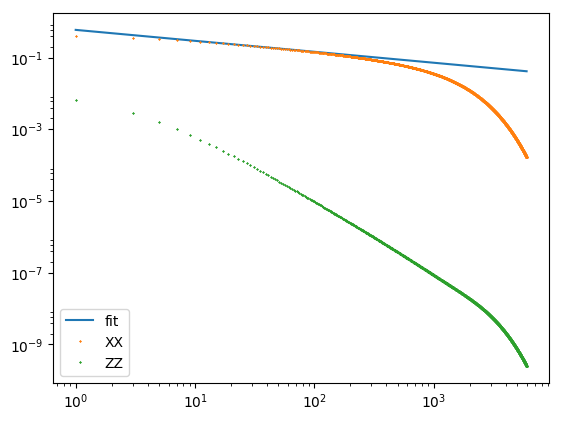

3.055e-01 (exact value -2.500e-01)

PyObject <matplotlib.legend.Legend object at 0x7fb562749410>

In [30]:
xpoints = vcat(1:2:2*m)

# A simple linear fit
n1, n2 = 5, 50  # The points to consider in the fit.
logxsamples = log.(xpoints[n1:n2])
logvaluesamples = log.(abs.(Xcorrs[n1:n2]))
a, b = linreg(logxsamples, logvaluesamples)
@printf("Critical exponent for XX correlator: %.3e (exact value %.3e)", b, -1/4)
fit = [exp(a) * i^b for i in xpoints]

# Behold the polynomial decay of correlators, up to some finite
# distance, after which the nature of the MPS state takes over
# and leads to an exponential dive. Note how different this
# behavior is from the one we observed before for a random MPS.
# For the exact critical ground state, the polynomial decay should
# continue indefinitely.
loglog(xpoints, fit; label="fit")
loglog(xpoints, abs.(Xcorrs); marker="x", ms=1, ls="", label="XX")
loglog(xpoints, abs.(Zcorrs); marker="x", ms=1, ls="", label="ZZ")
legend()

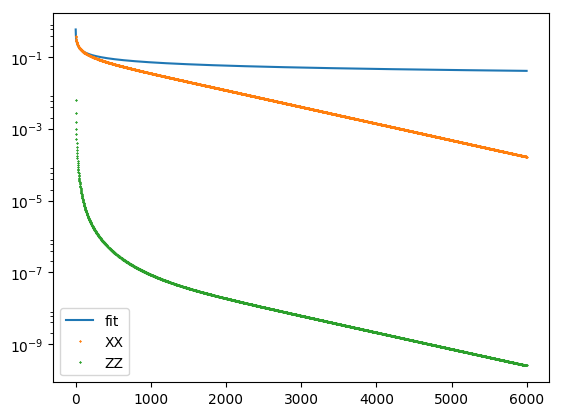

PyObject <matplotlib.legend.Legend object at 0x7fb5623f6510>

In [31]:
# The same in semilogy, to illustrate the exponential decay
# after a point.
semilogy(xpoints, fit; label="fit")
semilogy(xpoints, abs.(Xcorrs); marker="x", ms=1, ls="", label="XX")
semilogy(xpoints, abs.(Zcorrs); marker="x", ms=1, ls="", label="ZZ")
legend()

### From here on, you could do a number of things:

Apply all this to a different model,<br>
evaluate various things for the ground state you have,<br>
explore how the ground state changes when you vary the external magnetic field,<br>
look at dynamics when you excite the ground state (iTEBD can do real time evolution too!),<br>
etc.